### Setting up connection to EMS

In [6]:
import pandas as pd
import numpy as np

from pycelonis import get_celonis
from pycelonis import pql
import re
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score

from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm


import seaborn as sns
from sklearn.preprocessing import PowerTransformer

In [7]:
celonis = get_celonis()

In [3]:
### Data extraction from Celonis report

# space = celonis.spaces.find("XXX")
# package = space.packages.find("XXX")
# analysis = package.analyses.find("XXX")
# sheet = analysis.draft.sheets.find("XXX")
# component = sheet.components.find('XXX')
# df = component.get_data_frame()

In [21]:
# Data from csv in order not to wait for export from celonis (above)

df_grouped = pd.read_csv("Source data/PO_values_volumes_from_report.csv")
df_grouped = df_grouped.rename(columns={"Round_Day(CREATION_DATE_PO_ITEM)": "CREATION_DATE_PO_ITEM", "Net Order Value": "NETWR_CONVERTED"}).drop("# POs", axis = 1)

In [6]:
def fill_zero(text):
    if len(text) == 6:
        return text[:4] + "-" + "0" + text[5:]
    else:
        return text


df_grouped["CREATION_DATE_PO_ITEM"] = df_grouped["CREATION_DATE_PO_ITEM"].apply(fill_zero)
df_grouped.sort_values(by = "CREATION_DATE_PO_ITEM", inplace = True)

In [7]:
# Removing an outlier with extreme value of 1.2 M within single PO in 2021/3 # --> better would be to identify outliers e.g. based on zscores
df_grouped['NETWR_CONVERTED'] = df_grouped['NETWR_CONVERTED'].replace([1942170877.9945884], 1942170877.9945884-1200000000)                           

[2023-04-28 08:59:46] INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2023-04-28 08:59:46] INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


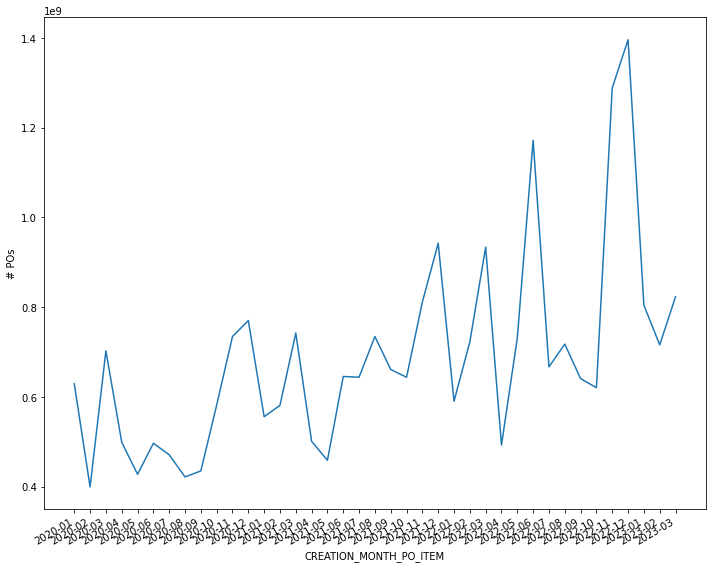

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(df_grouped['CREATION_DATE_PO_ITEM'], df_grouped['NETWR_CONVERTED'])
ax.set_xlabel('CREATION_MONTH_PO_ITEM')
ax.set_ylabel('# POs')
fig.autofmt_xdate()
plt.tight_layout()

df_grouped.set_index("CREATION_DATE_PO_ITEM", inplace = True)

array([[<AxesSubplot:title={'center':'NETWR_CONVERTED'}>]], dtype=object)

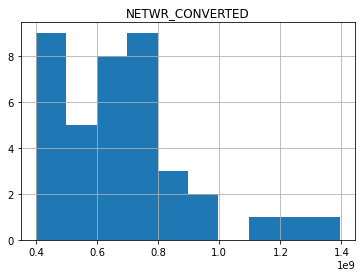

In [9]:
df_grouped.hist(column='NETWR_CONVERTED')

### Box-Cox Transformation --> trying to achieve normal distribution 

array([[<AxesSubplot:title={'center':'TRANSFORMED_NETWR_CONVERTED'}>]],
      dtype=object)

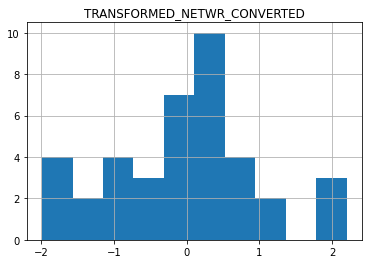

In [10]:
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import PowerTransformer


power = PowerTransformer(method='box-cox', standardize=True)
df_grouped["TRANSFORMED_NETWR_CONVERTED"] = power.fit_transform(df_grouped['NETWR_CONVERTED'].to_numpy().reshape(-1, 1))
#df_grouped.drop('# POs', axis = 1, inplace = True)

df_grouped.hist(column='TRANSFORMED_NETWR_CONVERTED')

In [11]:
train=df_grouped[0:32] 
test=df_grouped[32:]

<Figure size 432x288 with 0 Axes>

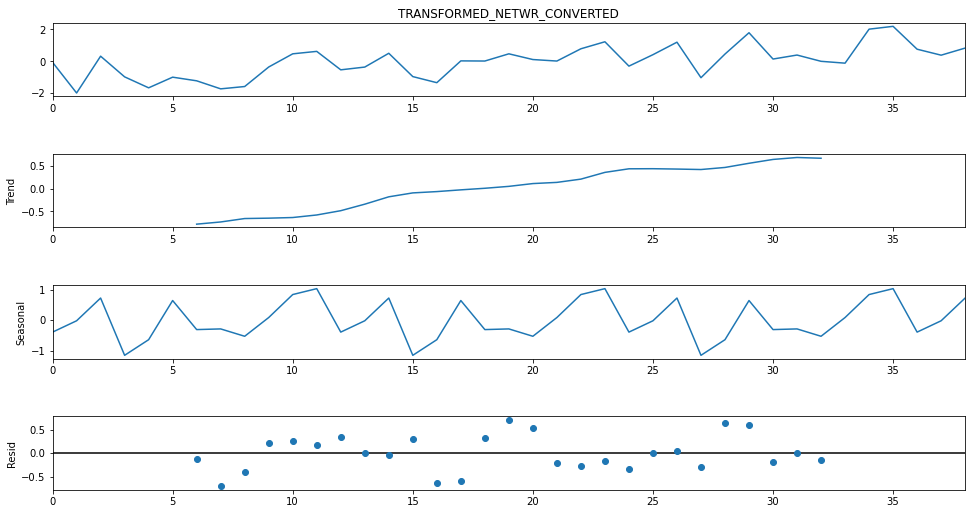

In [12]:
decomposition = seasonal_decompose(df_grouped.reset_index().TRANSFORMED_NETWR_CONVERTED, period = 12)  
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

## ETS model fit + prediction + CI intervals

In [14]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

df_grouped_copy_train = train.copy()
df_grouped_copy_test = test.copy()

# Build model.
ets_model = ETSModel(
    endog=df_grouped_copy_train['TRANSFORMED_NETWR_CONVERTED'], # y should be a pd.Series
    seasonal='add',
    trend = 'add',
    seasonal_periods=12,
    damped_trend = True,
    initialization_method = 'estimated'
)
ets_result = ets_model.fit()
print(ets_result)

# Simulate predictions - parameter estimation
n_steps_prediction = df_grouped_copy_train['TRANSFORMED_NETWR_CONVERTED'].shape[0]
n_repetitions = 500

df_simul = ets_result.simulate(
    nsimulations=n_steps_prediction,
    repetitions=n_repetitions,
    anchor='start',
)


# Calculate confidence intervals.
upper_ci = df_simul.quantile(q=0.95, axis='columns')
lower_ci = df_simul.quantile(q=0.05, axis='columns')

# Predicting
ci = ets_result.get_prediction(start =  '2022-09-01', end = '2023-12-01')
# ci = ets_result.get_prediction(start =  '2023-03-01', end = '2023-12-01')
preds = ci.pred_int(alpha = .05) #confidence interval
limits = ci.predicted_mean

preds = pd.concat([limits, preds], axis = 1)
preds.columns = ['ETS_FORECAST', 'LOWER_CI', 'UPPER_CI']




# Fixing inconsistency in dtype after generated prediction
preds.reset_index(inplace = True)
preds["index"] = pd.to_datetime(preds['index'], format='%Y-%m-%')
preds['index'] = preds['index'].apply(lambda x:x.strftime('%Y-%m'))
preds = preds.rename(columns = {'index' : 'CREATION_DATE_PO_ITEM'}).set_index('CREATION_DATE_PO_ITEM')

merged_df = pd.concat([preds, df_grouped_copy_train], axis=1).reset_index().sort_values(by = 'CREATION_DATE_PO_ITEM').set_index('CREATION_DATE_PO_ITEM')

#rms = sqrt(mean_squared_error(merged_df.dropna().TRANSFORMED_NETWR_CONVERTED, merged_df.dropna().ETS_FORECAST))
#print(f"RMSE: {rms}"))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.44316D+00    |proj g|=  4.33930D-01

At iterate    1    f=  1.35190D+00    |proj g|=  7.04086D-01

At iterate    2    f=  1.29658D+00    |proj g|=  3.39973D-01

At iterate    3    f=  1.28263D+00    |proj g|=  1.88257D-01

At iterate    4    f=  1.28010D+00    |proj g|=  3.84426D-01

At iterate    5    f=  1.27849D+00    |proj g|=  4.26525D-01

At iterate    6    f=  1.26890D+00    |proj g|=  4.53278D-01

At iterate    7    f=  1.19039D+00    |proj g|=  6.92986D-01

At iterate    8    f=  1.17836D+00    |proj g|=  2.39626D-01

At iterate    9    f=  1.17790D+00    |proj g|=  3.42535D-01

At iterate   10    f=  1.17033D+00    |proj g|=  1.90109D-01

At iterate   11    f=  1.16860D+00    |proj g|=  1.57275D-01

At iterate   12    f=  1.16604D+00    |proj g|=  1.83473D-01

At iterate   13    f=  1.1

/home/jovyan/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Inverse transformation to original scale

In [15]:
from sklearn.preprocessing import PowerTransformer
import numpy as np
import pandas as pd

def inverse_transform(df, pt_instance, features):
    for feature in features:
        df[feature] = pt_instance.inverse_transform(np.array(df[feature]).reshape(-1,1))
    return df

df_back_transformed = inverse_transform(merged_df, power, ['TRANSFORMED_NETWR_CONVERTED','ETS_FORECAST','LOWER_CI', 'UPPER_CI'])

In [16]:
# Back to the original value in 2021/3 
df_back_transformed.loc['2021-03']['TRANSFORMED_NETWR_CONVERTED'] = df_back_transformed.loc['2021-03']['TRANSFORMED_NETWR_CONVERTED'] = 1942170877.9945884

df_back_transformed.drop('NETWR_CONVERTED', axis = 1, inplace = True)

In [17]:
# Comment the line if applied to whole dataset
test = inverse_transform(df_grouped_copy_test, power, ['TRANSFORMED_NETWR_CONVERTED']).drop('NETWR_CONVERTED', axis = 1)
df_train_test = pd.concat([df_back_transformed, test.rename(columns = {'TRANSFORMED_NETWR_CONVERTED': 'TEST_DATA_NETWR_CONVERTED'})], axis=1).reset_index().sort_values(by = 'CREATION_DATE_PO_ITEM').set_index('CREATION_DATE_PO_ITEM')

### Graph

[2023-04-28 08:59:48] INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2023-04-28 08:59:48] INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2023-04-28 08:59:48] INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2023-04-28 08:59:48] INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2023-04-28 08:59:48] INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these

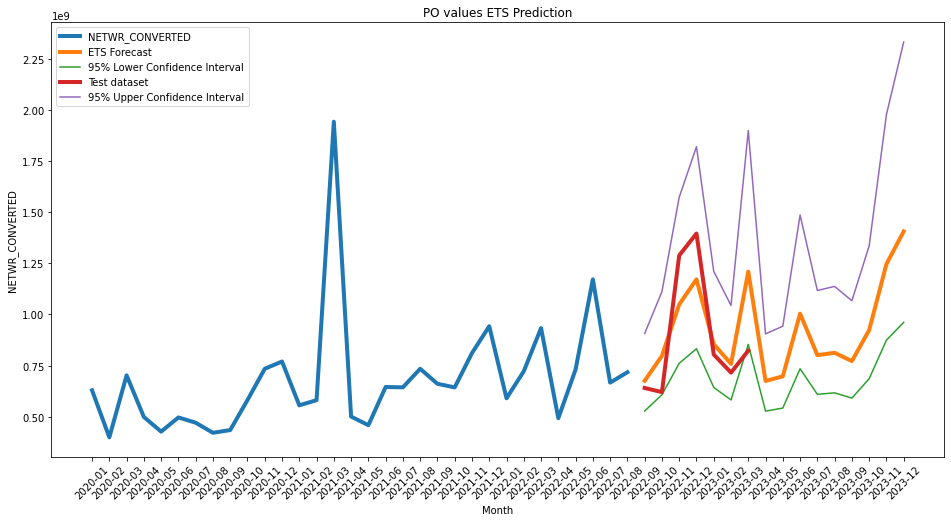

In [18]:
plt.figure(figsize=(16,8))
plt.title("PO values ETS Prediction")
plt.plot(df_back_transformed['TRANSFORMED_NETWR_CONVERTED'], label='NETWR_CONVERTED', linewidth = 4)
plt.plot(df_back_transformed['ETS_FORECAST'], label='ETS Forecast', linewidth = 4)
plt.plot(df_back_transformed['LOWER_CI'], label='95% Lower Confidence Interval')
plt.plot(test['TRANSFORMED_NETWR_CONVERTED'], label='Test dataset', linewidth = 4)
plt.xlabel("Month")
plt.ylabel("NETWR_CONVERTED")
plt.plot(df_back_transformed['UPPER_CI'], label='95% Upper Confidence Interval')
plt.xticks(rotation = 45)
plt.legend(loc='best')
plt.show()

### Pushing data to EMS

In [19]:
# For pushing the prediction based on whole dataset replace df_back_transformed with df_train_test  

from file_toolbox import send_mail
def send_alert_mail():
    send_mail(from_mail="XXX",
               to_mail=["XXX"],
               subject="ETS Prediction push failed",
               body="PO values ETS prediction push to EMS failed, please check.")

# push to EMS - (global workbench) and execute the datajob in global workbench to transform the table into PHB
try:
    data_pool = celonis.pools.find("XXX")
    data_pool.create_table(table_name="P2P_PO_VALUES_PREDICTION",
                       df_or_path=df_train_test.rename(columns={"TRANSFORMED_NETWR_CONVERTED": "NETWR_CONVERTED"}).reset_index().sort_values(by = "CREATION_DATE_PO_ITEM", ascending = True),
                       if_exists="drop")
    datajob = data_pool.data_jobs.find("XXX")
    datajob.execute()
    
    print("Data successfully pushed into EMS.")
except:
    send_alert_mail()

[2023-04-28 08:59:48] INFO: Data push job started...
[2023-04-28 08:59:53] INFO: Data push job status: QUEUED...
[2023-04-28 08:59:58] INFO: Data push job status: QUEUED...
[2023-04-28 09:00:03] INFO: Data push job status: QUEUED...
[2023-04-28 09:00:09] INFO: Data push job status: QUEUED...
[2023-04-28 09:00:14] INFO: Data push job status: QUEUED...
[2023-04-28 09:00:19] INFO: Data push job status: QUEUED...
[2023-04-28 09:00:23] INFO: Data push job status: DONE
Data successfully pushed into EMS.
